/opt/conda/lib/python3.7/site-packages/torchvision/datasets/imagenet.py:50: RuntimeWarning: The use of the download flag is deprecated, since the dataset is no longer publicly accessible.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/workspace/Libra_cam/cams/Libra_cam.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp_proba = F.softmax(temp_logits)
/workspace/Libra_cam/cams/calibration_util.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  masked_confi = F.softmax(logits).T[label][0].detach().cpu().numpy()
/workspace/Libra_cam/cams/relevance_cam_utils/LRP_util.py:330: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the 

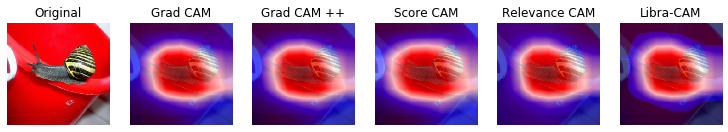

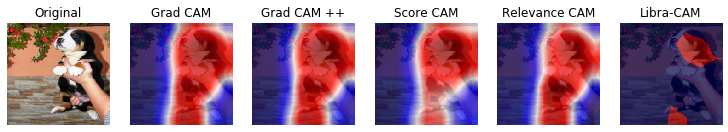

In [1]:
### import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import random

import os
import GPUtil
import numpy as np
import random
import torch.backends.cudnn as cudnn

from cams.Libra_cam import *
from cams.Multi_cam import *
from cams.calibration_util import *

from PIL import Image, ImageDraw
from models.relevance import vgg,resnet

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

testset = torchvision.datasets.ImageNet('../Dataset/Data/imagenet',
                            split='val', download=False, transform=transform)

#test_model = 'vgg'
test_model = 'resnet'

if test_model == 'vgg':
    model = vgg.vgg16_bn(pretrained = True).cuda()
else:
    model = resnet.resnet50(pretrained = True).cuda()
    
input_path = './samples/'

output_path = './Results/'
if not os.path.isdir(output_path):
    os.makedirs(output_path)

files = os.listdir(input_path)
    
model.eval()

lib_path = './library/lib.npy' #Library path
ref_library = np.load(lib_path,allow_pickle=True)

for imgname in files:
    if imgname.endswith('jpg'):
        input_img = input_path + imgname
    else:
        continue
    img = Image.open(input_img).convert("RGB")
    
    img_tensor = img.copy()

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img_tensor)
    img_tensor = img_tensor.unsqueeze(axis=0)

    output = F.softmax(model(img_tensor.cuda()))
    label = output.argmax()

    target_confi = output.T[label].detach().cpu().numpy().squeeze()
    confi = output.T[label]
    ref_count = 30
    ref_libra = ref_library[label]
    temp_cam = Libra_cam(test_model,model,img_tensor,ref_libra,label,ref_count,confi)
    calibrated_l_cam = get_best_threshold(temp_cam,model,output,label,img_tensor)
    
    grad_cam,grad_cam_pp,relevance_cam,score_cam = multi_CAM(test_model,model,img_tensor)
    
    img_tensor2 = img.copy()

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])

    target_img = transform(img_tensor2).numpy().transpose(1,2,0)
    
    fig = plt.figure(figsize=(15, 15))
    plt.subplots_adjust(bottom=0.01)

    plt.subplot(2, 7, 1)
    plt.imshow(target_img)
    plt.axis("off")
    plt.title('Original')
    
    plt.subplot(2, 7, 2)
    plt.imshow((grad_cam),cmap='seismic')
    plt.imshow(target_img,alpha = 0.3)
    plt.axis("off")
    plt.title('Grad CAM')
    
    plt.subplot(2, 7, 3)
    plt.imshow((grad_cam_pp),cmap='seismic')
    plt.imshow(target_img,alpha = 0.3)
    plt.axis("off")
    plt.title('Grad CAM ++')
    
    plt.subplot(2, 7, 4)
    plt.imshow((score_cam),cmap='seismic')
    plt.imshow(target_img,alpha = 0.3)
    plt.axis("off")
    plt.title('Score CAM')
    
    plt.subplot(2,7,5)
    plt.imshow((relevance_cam),cmap='seismic')
    plt.imshow(target_img,alpha = 0.3)
    plt.axis("off")
    plt.title('Relevance CAM')
    
    plt.subplot(2,7,6)
    plt.imshow((calibrated_l_cam),cmap='seismic')
    plt.imshow(target_img,alpha = 0.3)
    plt.axis("off")
    plt.title('Libra-CAM')

    plt.show()
    plt.close()